In [1]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train = pd.read_csv('gdrive/My Drive/probspace_youtube/train_data.csv')

In [4]:
test = pd.read_csv('gdrive/My Drive/probspace_youtube/test_data.csv')

In [5]:
combine = [train,test]

In [6]:
combine[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19720 entries, 0 to 19719
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 19720 non-null  int64 
 1   video_id           19720 non-null  object
 2   title              19720 non-null  object
 3   publishedAt        19720 non-null  object
 4   channelId          19720 non-null  object
 5   channelTitle       19720 non-null  object
 6   categoryId         19720 non-null  int64 
 7   collection_date    19720 non-null  object
 8   tags               19719 non-null  object
 9   likes              19720 non-null  int64 
 10  dislikes           19720 non-null  int64 
 11  comment_count      19720 non-null  int64 
 12  thumbnail_link     19720 non-null  object
 13  comments_disabled  19720 non-null  bool  
 14  ratings_disabled   19720 non-null  bool  
 15  description        19408 non-null  object
 16  y                  19720 non-null  int64

## 1.データを使える形へ変換

In [7]:
#ターゲット変数を対数変換
combine[0]['log_y'] = np.log(combine[0]['y'])

In [8]:
test = test.assign(y=0)
test = test.assign(log_y=0.0)

In [9]:
#投稿してから日が浅い動画はうまく予測できていないため、日付をタイムスタンプに変換して予測に使用する
for dataset in combine:
  dataset['publishedAt(date)'] = pd.to_datetime(dataset['publishedAt'],format='%Y-%m-%d')

In [10]:
for dataset in combine:
  dataset['publishedTimestamp'] = dataset['publishedAt(date)'].apply(lambda x:int(x.timestamp()/3600))

In [11]:
for dataset in combine:
  dataset['publishedAt(month)'] = dataset['publishedAt(date)'].apply(lambda x:str(x.month) if x.month >= 10 else str(0) + str(x.month))

In [12]:
for dataset in combine:
  dataset['publishedAt(year)'] = dataset['publishedAt(date)'].apply(lambda x:str(x.year))

In [13]:
for dataset in combine:
  dataset['publishedAt(weekDay)'] = dataset['publishedAt(date)'].apply(lambda x:x.weekday)

In [14]:
#日付は関係なさそう
for dataset in combine:
  dataset['publishedAt(day)'] = dataset['publishedAt(date)'].apply(lambda x:x.day)

In [15]:
for dataset in combine:
  dataset['publishedAt(year+month)'] = dataset['publishedAt(year)'] + dataset['publishedAt(month)']

In [17]:
for dataset in combine:
  #カテゴリごとに流行り廃りがあると考えたため、年月とカテゴリIDを合わせた特徴を作成
  dataset['publishedYear+categoryId'] = dataset['publishedAt(year)'] + dataset['categoryId'].astype(str)
  dataset['publishedYM+categoryId'] = dataset['publishedAt(year+month)'] + dataset['categoryId'].astype(str)

  dataset['publishedAt(month)'] = dataset['publishedAt(month)'].astype(int)
  dataset['publishedAt(year)'] = dataset['publishedAt(year)'].astype(int)
  dataset['publishedAt(year+month)'] = dataset['publishedAt(year+month)'].astype(int)
  dataset['publishedYear+categoryId'] = dataset['publishedYear+categoryId'].astype(int)
  dataset['publishedYM+categoryId'] = dataset['publishedYM+categoryId'].astype(int)

In [18]:
 combine[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19720 entries, 0 to 19719
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        19720 non-null  int64              
 1   video_id                  19720 non-null  object             
 2   title                     19720 non-null  object             
 3   publishedAt               19720 non-null  object             
 4   channelId                 19720 non-null  object             
 5   channelTitle              19720 non-null  object             
 6   categoryId                19720 non-null  int64              
 7   collection_date           19720 non-null  object             
 8   tags                      19719 non-null  object             
 9   likes                     19720 non-null  int64              
 10  dislikes                  19720 non-null  int64              
 11  comment_count  

In [19]:
combine[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29582 entries, 0 to 29581
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        29582 non-null  int64              
 1   video_id                  29582 non-null  object             
 2   title                     29582 non-null  object             
 3   publishedAt               29582 non-null  object             
 4   channelId                 29582 non-null  object             
 5   channelTitle              29582 non-null  object             
 6   categoryId                29582 non-null  int64              
 7   collection_date           29582 non-null  object             
 8   tags                      29582 non-null  object             
 9   likes                     29582 non-null  int64              
 10  dislikes                  29582 non-null  int64              
 11  comment_count  

In [20]:
for dataset in combine:
  dataset['collection_date'] = pd.to_datetime(dataset['collection_date'],format='%y.%d.%m',utc=True)
  dataset['collection_date(year)'] = dataset['collection_date'].apply(lambda x:str(x.year))
  dataset['collection_date(month)'] = dataset['collection_date'].apply(lambda x:str(x.month) if x.month >= 10 else str(0) + str(x.month))

  dataset['collection_date(day)'] = dataset['collection_date'].apply(lambda x:x.day)
  dataset['collection_date(year+month)'] = dataset['collection_date(year)'] + dataset['collection_date(month)']

  dataset['collection_timestamp'] = dataset['collection_date'].apply(lambda x:int(x.timestamp()/3600))
  dataset['collection_term(day)'] = dataset.apply(lambda x:x['collection_date']-x['publishedAt(date)'],axis=1)
  dataset['collection_term(day)'] = dataset['collection_term(day)'].apply(lambda x:x.days)

  dataset['collection_date(month)'] = dataset['collection_date(month)'].astype(int)
  dataset['collection_date(year)'] = dataset['collection_date(year)'].astype(int)
  dataset['collection_date(year+month)'] = dataset['collection_date(year+month)'].astype(int)

In [21]:
combine[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19720 entries, 0 to 19719
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   id                           19720 non-null  int64              
 1   video_id                     19720 non-null  object             
 2   title                        19720 non-null  object             
 3   publishedAt                  19720 non-null  object             
 4   channelId                    19720 non-null  object             
 5   channelTitle                 19720 non-null  object             
 6   categoryId                   19720 non-null  int64              
 7   collection_date              19720 non-null  datetime64[ns, UTC]
 8   tags                         19719 non-null  object             
 9   likes                        19720 non-null  int64              
 10  dislikes                     19720 non-null  i

In [22]:
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0)

In [23]:
#freqency encoding チャンネルIDを出現する回数で変換
channelSize = tmp_train_test.groupby('channelId').size()
tmp_train_test['channelSize'] = tmp_train_test['channelId'].map(channelSize)
combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:]

In [24]:
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0)

In [25]:
#freqency encoding カテゴリIDを出現する回数で変換
#データ数が少ないカテゴリは「99:その他」とする
tmp_train_test = tmp_train_test.replace({'categoryId':{44:99,43:99,30:99,29:99}})
categorySize = tmp_train_test.groupby('categoryId').size()
tmp_train_test['categorySize'] = tmp_train_test['categoryId'].map(categorySize)
combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:]

In [26]:
#「|」で区切られたタグをリスト型に変換し、タグの個数を特徴として作成
for dataset in combine:
  dataset['tagList'] = dataset['tags'].apply(lambda x:str(x).split('|'))
  dataset['tagCount'] = dataset['tagList'].apply(lambda x:0 if '[none]' in x else len(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0)

In [28]:
#全データを探索し、各タグの出現回数を格納
tag_count = dict()

for index,row in tmp_train_test.iterrows():
  for tagName in row['tagList']:
    if tagName in tag_count.keys():
      tag_count[tagName] += 1
    else:
      tag_count[tagName] = 1

tag_count['[none]'] = 0

In [29]:
#よく使われるタグを使うと視聴数が増えると考えられるため、タグの登場頻度を特徴として追加する
tmp_train_test = tmp_train_test.assign(tag_population=0)

for index,row in tmp_train_test.iterrows():
  tmp_population = 0
  for tagName in row['tagList']:
    tmp_population += tag_count[tagName]
  tmp_train_test.loc[index,'tag_population'] = tmp_population / len(row['tagList'])

combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:]

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0)


## 2.特徴量を作成

In [31]:
combine[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19720 entries, 0 to 19719
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   id                           19720 non-null  int64              
 1   video_id                     19720 non-null  object             
 2   title                        19720 non-null  object             
 3   publishedAt                  19720 non-null  object             
 4   channelId                    19720 non-null  object             
 5   channelTitle                 19720 non-null  object             
 6   categoryId                   19720 non-null  int64              
 7   collection_date              19720 non-null  datetime64[ns, UTC]
 8   tags                         19719 non-null  object             
 9   likes                        19720 non-null  int64              
 10  dislikes                     19720 non-null  i

In [32]:
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0)
tmp_train_test = tmp_train_test.drop([
                                      'id',
                                      'video_id',
                                      'publishedAt',
                                      'publishedAt(date)',
                                      'channelId',
                                      'channelTitle',
                                      'collection_date',
                                      'tags',
                                      'thumbnail_link',
                                      'y'
                                      ],axis=1)

combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:]
combine[1] = combine[1].drop('log_y',axis=1)

In [33]:
combine[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19720 entries, 0 to 19719
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        19720 non-null  object 
 1   categoryId                   19720 non-null  int64  
 2   likes                        19720 non-null  int64  
 3   dislikes                     19720 non-null  int64  
 4   comment_count                19720 non-null  int64  
 5   comments_disabled            19720 non-null  bool   
 6   ratings_disabled             19720 non-null  bool   
 7   description                  19408 non-null  object 
 8   log_y                        19720 non-null  float64
 9   publishedTimestamp           19720 non-null  int64  
 10  publishedAt(month)           19720 non-null  int64  
 11  publishedAt(year)            19720 non-null  int64  
 12  publishedAt(weekDay)         19720 non-null  int64  
 13  publishedAt(day)

In [34]:
combine[1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29582 entries, 0 to 29581
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        29582 non-null  object 
 1   categoryId                   29582 non-null  int64  
 2   likes                        29582 non-null  int64  
 3   dislikes                     29582 non-null  int64  
 4   comment_count                29582 non-null  int64  
 5   comments_disabled            29582 non-null  bool   
 6   ratings_disabled             29582 non-null  bool   
 7   description                  29104 non-null  object 
 8   publishedTimestamp           29582 non-null  int64  
 9   publishedAt(month)           29582 non-null  int64  
 10  publishedAt(year)            29582 non-null  int64  
 11  publishedAt(weekDay)         29582 non-null  int64  
 12  publishedAt(day)             29582 non-null  int64  
 13  publishedAt(year

In [35]:
#標準化は精度が下がったため削除
#from sklearn.preprocessing import StandardScaler

#tmp_train_test = pd.concat([combine[0],combine[1]],axis=0)
#sc = StandardScaler()
#sc.fit(tmp_train_test.drop('log_y',axis=1))
#combine[0] = sc.transform(tmp_train_test.drop('log_y',axis=1)[:19720])
#combine[1] = sc.transform(tmp_train_test.drop('log_y',axis=1)[19720:])

#combine[0] = pd.DataFrame(combine[0],columns=tmp_train_test.drop('log_y',axis=1).columns)
#combine[1] = pd.DataFrame(combine[1],columns=tmp_train_test.drop('log_y',axis=1).columns)

#combine[0]['log_y'] = tmp_train_test[:19720]['log_y']

In [36]:
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0)

In [37]:
tmp_train_test['publishedTimestampBand'] = pd.cut(tmp_train_test['publishedTimestamp'],10,labels=False)

In [38]:
combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:]

In [39]:
tmp_train_test['channelLevel'] = pd.qcut(tmp_train_test['channelSize'],6,duplicates='drop',labels=[1,2,3,4,5])
tmp_train_test['channelLevel'] = tmp_train_test['channelLevel'].astype(int)
combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:]

In [40]:
tmp_train_test['categoryLevel'] = pd.qcut(tmp_train_test['categorySize'],7,duplicates='drop',labels=[1,2,3,4,5])
tmp_train_test['categoryLevel'] = tmp_train_test['categoryLevel'].astype(int)
combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:]

In [41]:
#カテゴリ規模とチャンネル規模を掛け合わせた特徴を作成
for dataset in combine:
  dataset['categoryChannelLevel'] = (dataset['categoryLevel']) * (dataset['channelLevel'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
#ライク数、ディスライク数、コメント数は視聴数に直結すると考えらるため、それらを合計した特徴を作成
for dataset in combine:
  dataset['population'] = (dataset['likes']) + (dataset['dislikes']) + (dataset['comment_count'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
#ライク数の割合、ディスライク数の割合などの特徴を作成
for dataset in combine:
  dataset['like_ratio'] = dataset['likes'] / dataset['population']
  dataset['dislike_ratio'] = dataset['dislikes'] / dataset['population']
  dataset['comment_ratio'] = dataset['comment_count'] /  dataset['population']
  
  dataset['like_ratio'] = dataset['like_ratio'].fillna(0)
  dataset['dislike_ratio'] = dataset['dislike_ratio'].fillna(0)
  dataset['comment_ratio'] = dataset['comment_ratio'].fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [44]:
#自然言語処理用のパッケージをインストール
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.7)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.10)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+ma

In [45]:
#形態素解析
import MeCab
def get_word(text):
  tagger = MeCab.Tagger('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
  tagger.parse('')
  node = tagger.parseToNode(text)
  word_list = []
  while node:
    pos = node.feature.split(',')[0]
    if pos in ['名詞','動詞','形容詞']:
      word_list.append(node.surface)
    node = node.next
  #return ' '.join(word_list)
  return word_list

for dataset in combine:
  dataset['fixed_title'] = dataset['title'].apply(lambda x:get_word(x))
  dataset['description'] = dataset['description'].fillna('NULL')
  dataset['fixed_description'] = dataset['description'].apply(lambda x:get_word(x))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [46]:
from sklearn.feature_extraction import text
import nltk
stop_words_eng = text.ENGLISH_STOP_WORDS
nltk.download('stopwords')
stop_word_nltk = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
import urllib
url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
stop_words_jpn_file = urllib.request.urlopen(url)
stop_words_jpn = [line.decode('utf-8').strip() for line in stop_words_jpn_file]

In [48]:
stop_words = stop_words_jpn + list(stop_words_eng) + stop_word_nltk

In [49]:
#不要な単語を取り除き、文章を単語ごとに分けたリストに変換
def delete_stop_word(x):
  word_list = [w.lower() for w in x if not w.lower() in stop_words]
  #words = ' '.join(word_list)
  #return words
  return word_list

for dataset in combine:
  dataset['fixed_title'] = dataset['fixed_title'].apply(lambda x:delete_stop_word(x))
  dataset['fixed_description'] = dataset['fixed_description'].apply(lambda x:delete_stop_word(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [50]:
import gensim

In [51]:
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0).reset_index(drop=True)
title_dictionary = gensim.corpora.Dictionary(tmp_train_test['fixed_title'])
desc_dictionary = gensim.corpora.Dictionary(tmp_train_test['fixed_description'])

In [52]:
#単語リストをbag of word 形式に変換
tmp_train_test['title_corpus'] = tmp_train_test['fixed_title'].apply(lambda x:title_dictionary.doc2bow(x))
tmp_train_test['description_corpus'] = tmp_train_test['fixed_description'].apply(lambda x:desc_dictionary.doc2bow(x))

In [53]:
title_corpus = list(tmp_train_test['title_corpus'])
desc_corpus = list(tmp_train_test['description_corpus'])

In [54]:
#タイトルと概要を１１個のトピックに分類
title_lda = gensim.models.ldamodel.LdaModel(corpus=title_corpus,num_topics=11,id2word=title_dictionary)
desc_lda = gensim.models.ldamodel.LdaModel(corpus=desc_corpus,num_topics=11,id2word=desc_dictionary)


#coherences = []
#perplexities = []
#for i in range(1,20):
#  title_lda = gensim.models.ldamodel.LdaModel(corpus=tmp_train_test['title_corpus'],num_topics=i,id2word=title_dictionary)
#  perplexities.append(np.exp2(-title_lda.log_perplexity(tmp_train_test['title_corpus'])))
#  coherence_model = gensim.models.CoherenceModel(model=title_lda,texts=tmp_train_test['fixed_title'],dictionary=title_dictionary,coherence='c_v')
#  coherences.append(coherence_model.get_coherence())

#for i in range(1,20):
#  desc_lda = gensim.models.ldamodel.LdaModel(corpus=tmp_train_test['description_corpus'],num_topics=i,id2word=desc_dictionary)
#  perplexities.append(np.exp2(-desc_lda.log_perplexity(tmp_train_test['description_corpus'])))
#  coherence_model = gensim.models.CoherenceModel(model=desc_lda,texts=tmp_train_test['fixed_description'],dictionary=desc_dictionary,coherence='c_v')
#  coherences.append(coherence_model.get_coherence())


In [55]:
#11個のトピックの内一番確率が高いものを割り当てる
def get_title_topic_prob(x):
  max_prob = 0
  topic = -1
  for tmp in title_lda.get_document_topics(x):
    if max_prob < tmp[1]:
      max_prob = tmp[1]
      topic = tmp[0]
  
  return pd.Series([topic,max_prob])

def get_desc_topic_prob(x):
  max_prob = 0
  topic = -1
  for tmp in desc_lda.get_document_topics(x):
    if max_prob < tmp[1]:
      max_prob = tmp[1]
      topic = tmp[0]

  return pd.Series([topic,max_prob])

In [56]:
tmp_train_test[['title_topic','title_topic_prob']] = tmp_train_test['title_corpus'].apply(lambda x:get_title_topic_prob(x))
tmp_train_test[['description_topic','description_topic_prob']] = tmp_train_test['description_corpus'].apply(lambda x:get_desc_topic_prob(x))

In [57]:
#fig,ax1 = plt.subplots(figsize=(12,5))

#c1 = 'darkturquoise'
#ax1.plot(range(1,20),coherences,'o-',color=c1)
#ax1.set_xlabel('Num Topics')
#ax1.set_ylabel('Coherence',color=c1)
#ax1.tick_params('y',colors=c1)


#c2 = 'slategray'
#ax2 = ax1.twinx()
#ax2.plot(range(1,20),perplexities,'o-',color=c2)
#ax2.set_ylabel('Perplexity',color=c2)
#ax2.tick_params('y',colors=c2)

#ax1.set_xticks(range(1,20))
#fig.tight_layout()
#plt.show()
#plt.savefig('metrics.png')

In [58]:
combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:].reset_index(drop=True)

In [59]:
#tfidfでタイトルと概要をベクトル化
title_vectorizer = text.TfidfVectorizer()
desc_vectorizer = text.TfidfVectorizer()

tmp_train_test = pd.concat([combine[0],combine[1]],axis=0).reset_index(drop=True)


tmp_train_test['fixed_title_sep_space'] = tmp_train_test['fixed_title'].apply(lambda x:' '.join(x))
title_vectorizer.fit(tmp_train_test['fixed_title_sep_space'])
tmp_train_test['title_vector'] = title_vectorizer.transform(tmp_train_test['fixed_title_sep_space'])

tmp_train_test['fixed_description_sep_space'] = tmp_train_test['fixed_description'].apply(lambda x:' '.join(x))
desc_vectorizer.fit(tmp_train_test['fixed_description_sep_space'])
tmp_train_test['description_vector'] = desc_vectorizer.transform(tmp_train_test['fixed_description_sep_space'])

In [60]:
title_idf = dict(zip(title_vectorizer.get_feature_names(),title_vectorizer.idf_))
title_dfIdf = pd.DataFrame(columns=['idf']).from_dict(title_idf,orient='index')
title_dfIdf.columns = ['title_idf']

description_idf = dict(zip(desc_vectorizer.get_feature_names(),desc_vectorizer.idf_))
desc_dfIdf = pd.DataFrame(columns=['idf']).from_dict(description_idf,orient='index')
desc_dfIdf.columns = ['desc_idf']


In [61]:
title_dfIdf.sort_values(by='title_idf').to_csv('gdrive/My Drive/probspace_youtube/title_dfidf.csv')
desc_dfIdf.sort_values(by='desc_idf').to_csv('gdrive/My Drive/probspace_youtube/desc_dfidf.csv')

In [62]:
#カウントベクトル化を試したが精度が下がったため不採用
#tmp_train_test = pd.concat([combine[0],combine[1]],axis=0).reset_index(drop=True)
#count_vec = text.CountVectorizer(stop_words=stop_words,max_features=10000,max_df=.3)
#count_vec.fit(pd.concat([tmp_train_test['fixed_title'],tmp_train_test['fixed_description']],axis=0).values)

#title_count_vec = count_vec.transform(tmp_train_test['fixed_title'])
#description_count_vec = count_vec.transform(tmp_train_test['description'])

In [63]:
#概要欄を元にSNSの使用状況、公式動画などのフラグを特徴として作成
tmp_train_test['is_using_facebook'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:1 if 'フェイスブック' and 'facebook' in x else 0)
tmp_train_test['is_using_instagram'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:1 if 'インスタグラム' and'instagram' in x else 0)
tmp_train_test['is_using_twitter'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:1 if 'ツイッター' and 'twitter' in x else 0)
tmp_train_test['count_using_sns'] = tmp_train_test['is_using_facebook'] + tmp_train_test['is_using_instagram'] + tmp_train_test['is_using_twitter']
tmp_train_test['is_official(desc)'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:1 if '公式' and 'official' in x else 0)
tmp_train_test['count_url_in_description'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:x.count('http'))

tmp_train_test['is_official(title)'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:1 if '公式' and 'official' in x else 0)
tmp_train_test['is_movie'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:1 if 'movie' in x else 0)
tmp_train_test['is_music'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:1 if 'music' in x else 0)
tmp_train_test['is_mv'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:1 if 'mv' in x else 0)
tmp_train_test['is_anime'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:1 if 'アニメ' in x else 0)
tmp_train_test['is_pv'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:1 if 'pv' in x else 0)

In [64]:
#英語を使っている動画は視聴者が多いと予想されるため、英字数などを特徴として作成
import re
tmp_train_test['len_alphabet_description'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:len(re.findall('[a-z]',x)))
tmp_train_test['len_alphabet_title'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:len(re.findall('[a-z]',x)))
tmp_train_test['len_excep_alphabet_description'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:len(re.findall('[^a-z0-9~:;/!?=()【】『』,、。\.\s\-]',x)))
tmp_train_test['len_excep_alphabet_title'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:len(re.findall('[^a-z0-9~:;/!?=()【】『』,、。\.\s\-]',x)))
tmp_train_test['len_description'] = tmp_train_test['fixed_description_sep_space'].apply(lambda x:len(x))
tmp_train_test['len_title'] = tmp_train_test['fixed_title_sep_space'].apply(lambda x:len(x))
tmp_train_test['title_alphabet_ratio'] = tmp_train_test['len_alphabet_title'] / tmp_train_test['len_title']
tmp_train_test['description_alphabet_ratio'] = tmp_train_test['len_alphabet_description'] / tmp_train_test['len_description']
tmp_train_test['title_excep_alphabet_ratio'] = tmp_train_test['len_excep_alphabet_title'] / tmp_train_test['len_title']
tmp_train_test['description_excep_alphabet_ratio'] = tmp_train_test['len_excep_alphabet_description'] / tmp_train_test['len_description']


In [65]:
tmp_train_test['len_tag_alphabet'] = tmp_train_test['tagList'].apply(lambda x:len([tag for tag in x if re.search('[a-z]+',tag)]))
tmp_train_test['len_tag_not_alphabet'] = tmp_train_test['tagList'].apply(lambda x:len([tag for tag in x if re.search('[^a-zA-Z]',tag)]))
tmp_train_test['tag_alphabet_ratio'] = tmp_train_test['len_tag_alphabet'] / tmp_train_test['tagCount']

tmp_train_test['title_alphabet_ratio'] = tmp_train_test['title_alphabet_ratio'].fillna(0)
tmp_train_test['description_alphabet_ratio'] = tmp_train_test['description_alphabet_ratio'].fillna(0)
tmp_train_test['title_excep_alphabet_ratio'] = tmp_train_test['title_excep_alphabet_ratio'].fillna(0)
tmp_train_test['description_excep_alphabet_ratio'] = tmp_train_test['description_excep_alphabet_ratio'].fillna(0)
tmp_train_test['tag_alphabet_ratio'] = tmp_train_test['tag_alphabet_ratio'].replace(np.inf,1)

combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:].reset_index(drop=True)

In [66]:
#LDAのトピック分類は精度が下がったため不採用
#from sklearn.decomposition import LatentDirichletAllocation
#distances = []
#for i range(2,10):
#  title_lda_model = LatentDirichletAllocation(n_components=i,random_state=1,learning_method='batch')
#  title_lda = title_lda_model.fit_transform(title_count_vec)
#  title_lda.max(axis=1)


#description_lda_model = LatentDirichletAllocation(n_components=12,random_state=1,learning_method='batch')
#description_lda = description_lda_model.fit_transform(description_count_vec)

In [67]:
#n_top_words = 10
#feature_names = count_vec.get_feature_names()
#for topic_idx,topic in enumerate(title_lda_model.components_):
#  print('Topic %d:' % (topic_idx + 1))
#  print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [68]:
#tmp = title_lda[:,6].argsort()[::-1]
#for iter_idx,title_idx in enumerate(tmp[:5]):
#  print(iter_idx+1)
#  print(tmp_train_test['title'][title_idx])
#  print(title_idx)

In [69]:
#tmp_train_test['title_topic_prob'] = title_lda.max(axis=1)
#tmp_train_test['title_topic'] = title_lda.argmax(axis=1)
#tmp_train_test['description_topic_prob'] = description_lda.max(axis=1)
#tmp_train_test['description_topic'] = description_lda.argmax(axis=1)

In [70]:
combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:].reset_index(drop=True)

In [71]:
for dataset in combine:
  dataset['title_word_count'] = dataset['fixed_title'].apply(lambda x:len(x))
  dataset['description_word_count'] = dataset['fixed_description'].apply(lambda x:len(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
# 日付と試聴数の分布を見ると、ある時期を境に分布が急に変わっているため、そこを境に別々のモデルを作成する
# カテゴリごとにターゲットエンコード
# 同じチャンネルの動画は伸びやすいかも。チャンネルごとのレコード数を付与する。同じチャンネルの最高試聴数を付与する
#　学習データとテストデータでチャンネルIDカテゴリIDに偏りがあるかもしれないので調べる。あったらgroupkfoldをする

In [73]:
for dataset in combine:
  dataset['like_per_collection'] = dataset['likes'] / dataset['collection_term(day)']
  dataset['dislike_per_collection'] = dataset['dislikes'] / dataset['collection_term(day)']
  dataset['comment_per_collection'] = dataset['comment_count'] / dataset['collection_term(day)']
  dataset['population_per_collection'] = dataset['population'] / dataset['collection_term(day)']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [74]:
for dataset in combine:
  dataset['like_per_dislike'] = dataset['likes'] / dataset['dislikes']
  dataset['comment_per_dislike'] = dataset['comment_count'] / dataset['dislikes']
  dataset['population_per_dislike'] = dataset['population'] / dataset['dislikes']
  dataset['like_per_collect_timestamp'] = dataset['likes'] / dataset['collection_timestamp']
  dataset['dislike_per_collect_timestamp'] = dataset['dislikes'] / dataset['collection_timestamp']
  dataset['population_per_collect_timestamp'] = dataset['population'] / dataset['collection_timestamp']
  dataset['like_per_publish_timestamp'] = dataset['likes'] / dataset['publishedTimestamp']
  dataset['dislike_per_publish_timestamp'] = dataset['dislikes'] / dataset['publishedTimestamp']
  dataset['population_per_publish_timestamp'] = dataset['population'] / dataset['publishedTimestamp']

  dataset['like_per_dislike'] = dataset['like_per_dislike'].fillna(0)
  dataset['comment_per_dislike'] = dataset['comment_per_dislike'].fillna(0)
  dataset['population_per_dislike'] = dataset['population_per_dislike'].fillna(0)

  dataset['like_per_dislike'] = dataset['like_per_dislike'].replace(np.inf,1)
  dataset['comment_per_dislike'] = dataset['comment_per_dislike'].replace(np.inf,1)
  dataset['population_per_dislike'] = dataset['population_per_dislike'].replace(np.inf,1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [75]:
combine[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19720 entries, 0 to 19719
Data columns (total 88 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   title                             19720 non-null  object 
 1   categoryId                        19720 non-null  int64  
 2   likes                             19720 non-null  int64  
 3   dislikes                          19720 non-null  int64  
 4   comment_count                     19720 non-null  int64  
 5   comments_disabled                 19720 non-null  bool   
 6   ratings_disabled                  19720 non-null  bool   
 7   description                       19720 non-null  object 
 8   log_y                             19720 non-null  float64
 9   publishedTimestamp                19720 non-null  int64  
 10  publishedAt(month)                19720 non-null  int64  
 11  publishedAt(year)                 19720 non-null  int64  
 12  publ

In [76]:
#学習に不要なカラムを削除
tmp_train_test = pd.concat([combine[0],combine[1]],axis=0).reset_index(drop=True)

tmp_train_test = tmp_train_test.drop(
    ['title',
     'description',
     'tagList',
     'fixed_title',
     'fixed_description',
     'title_corpus',
     'description_corpus',
     'fixed_title_sep_space',
     'fixed_description_sep_space',
     'title_vector',
     'description_vector'
     ],
     axis=1)

In [77]:
tmp_train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49302 entries, 0 to 49301
Data columns (total 77 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   categoryId                        49302 non-null  int64  
 1   likes                             49302 non-null  int64  
 2   dislikes                          49302 non-null  int64  
 3   comment_count                     49302 non-null  int64  
 4   comments_disabled                 49302 non-null  bool   
 5   ratings_disabled                  49302 non-null  bool   
 6   log_y                             19720 non-null  float64
 7   publishedTimestamp                49302 non-null  int64  
 8   publishedAt(month)                49302 non-null  int64  
 9   publishedAt(year)                 49302 non-null  int64  
 10  publishedAt(weekDay)              49302 non-null  int64  
 11  publishedAt(day)                  49302 non-null  int64  
 12  publ

In [78]:
#Kmeansでクラスタ分析
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=5,random_state=0)
kmeans.fit(tmp_train_test.drop('log_y',axis=1))

clusters = kmeans.predict(tmp_train_test.drop('log_y',axis=1))
distances = kmeans.transform(tmp_train_test.drop('log_y',axis=1))

tmp_train_test['cluster'] = pd.Series(clusters,name='cluster')
tmp_train_test['distance'] = pd.Series(distances.min(axis=1),name='distance')

combine[0] = tmp_train_test[:19720]
combine[1] = tmp_train_test[19720:].reset_index(drop=True)

In [79]:
cat_columns = ['categoryId',
               'comments_disabled',
               'ratings_disabled',
               'publishedAt(month)',
               'publishedAt(year)',
               'publishedAt(weekDay)',
               'publishedAt(day)',
               'publishedAt(year+month)',
               'collection_date(year)',
               'collection_date(month)',
               'collection_date(day)',
               'collection_date(year+month)',
               'channelLevel',
               'categoryLevel',
               'categoryChannelLevel',
               'cluster',
               'title_topic',
               'description_topic',
               'is_using_facebook',
               'is_using_instagram',
               'is_using_twitter',
               'is_official(desc)',
               'is_official(title)',
               'is_movie',
               'is_music',
               'is_mv',
               'is_anime',
               'is_pv']

In [80]:
train_validation = tmp_train_test[:19720]
test_dataset = tmp_train_test[19720:].drop('log_y',axis=1).reset_index(drop=True)

In [81]:
#XGBoostで学習
#ターゲットエンコーディングは上手く実装できなかったため不採用
import xgboost as xgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler

valid_MSE_scores = []
valid_r2_scores = []

kf = KFold(n_splits=5,shuffle=True,random_state=0)
for train_idx,val_idx in kf.split(train_validation):
  x_train,y_train = train_validation.drop('log_y',axis=1).iloc[train_idx],train_validation['log_y'].iloc[train_idx]
  x_val,y_val = train_validation.drop('log_y',axis=1).iloc[val_idx],train_validation['log_y'].iloc[val_idx]

  tmpDataset = pd.concat([x_train,y_train],axis=1)

  #カテゴリーのターゲットエンコーディング
  #log_y_median = tmpDataset.groupby('categoryId')['log_y'].median()
  #x_val['categoryId'] = x_val['categoryId'].map(log_y_median)

  #チャンネルのターゲットエンコーディング
  #log_y_median = tmpDataset.groupby('channelLevel')['log_y'].median()
  #x_val['channelLevel'] = x_val['channelLevel'].map(log_y_median)

  #encoding_kf = KFold(n_splits=4,shuffle=True,random_state=0)
  #tmp_category_target = np.repeat(np.nan,x_train.shape[0])
  #tmp_channel_target = np.repeat(np.nan,x_train.shape[0])

  #for idx_1,idx_2 in encoding_kf.split(x_train):
    #カテゴリーのターゲットエンコーディング
    #log_y_median = tmpDataset.iloc[idx_1].groupby('categoryId')['log_y'].median()
    #tmp_category_target[idx_2] = x_train['categoryId'].iloc[idx_2].map(log_y_median)

    #動画数が少ないチャンネルのターゲットエンコーディング
    #log_y_median = tmpDataset.iloc[idx_1].groupby('channelLevel')['log_y'].median()
    #tmp_channel_target[idx_2] = x_train['channelLevel'].iloc[idx_2].map(log_y_median)

  #x_train['categoryId'] = tmp_category_target
  #x_train['channelLevel'] = tmp_channel_target


  #動画数が少ないチャンネルは少ないチャンネル間の平均で、動画数が多いチャンネルはチャンネル内の平均点でターゲットエンコーディング

  dtrain = xgb.DMatrix(x_train,label=y_train)
  dvalid = xgb.DMatrix(x_val,label=y_val)
  params = {'objective':'reg:squarederror',
            'eval_metric':'rmse',
            'random_state':1,
            'eta':0.1,
            'max_depth':8,
            'gamma':2,
            'min_child_weight':4
            }
  num_round = 110
  watch_list = [(dtrain,'train'),(dvalid,'eval')]

  model = xgb.train(params,dtrain,num_round,evals=watch_list)

  valid_pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
  

  print('------------------------------------------',np.sqrt(mean_squared_error(y_val,valid_pred)))
  valid_MSE_scores.append(np.sqrt(mean_squared_error(y_val,valid_pred)))
  valid_r2_scores.append(r2_score(y_val,valid_pred))

print('valid MSE:',np.mean(valid_MSE_scores))

[0]	train-rmse:11.0474	eval-rmse:11.0262
[1]	train-rmse:9.95305	eval-rmse:9.93506
[2]	train-rmse:8.96864	eval-rmse:8.95401
[3]	train-rmse:8.08331	eval-rmse:8.07131
[4]	train-rmse:7.28701	eval-rmse:7.2775
[5]	train-rmse:6.57122	eval-rmse:6.56449
[6]	train-rmse:5.92759	eval-rmse:5.92334
[7]	train-rmse:5.34897	eval-rmse:5.34697
[8]	train-rmse:4.82914	eval-rmse:4.8305
[9]	train-rmse:4.36226	eval-rmse:4.36674
[10]	train-rmse:3.94323	eval-rmse:3.951
[11]	train-rmse:3.56709	eval-rmse:3.57778
[12]	train-rmse:3.22947	eval-rmse:3.24525
[13]	train-rmse:2.92685	eval-rmse:2.94574
[14]	train-rmse:2.65584	eval-rmse:2.67924
[15]	train-rmse:2.41347	eval-rmse:2.44171
[16]	train-rmse:2.19651	eval-rmse:2.23052
[17]	train-rmse:2.00351	eval-rmse:2.04291
[18]	train-rmse:1.83185	eval-rmse:1.87761
[19]	train-rmse:1.67814	eval-rmse:1.73063
[20]	train-rmse:1.54206	eval-rmse:1.60163
[21]	train-rmse:1.42121	eval-rmse:1.48745
[22]	train-rmse:1.31483	eval-rmse:1.3889
[23]	train-rmse:1.21948	eval-rmse:1.29988
[24]	tr

In [82]:
score = model.get_score(importance_type='total_gain')
score = sorted([(k,v) for k,v in score.items()],key=lambda tpl:tpl[1],reverse=True)
score

[('dislike_per_publish_timestamp', 178084.63425428417),
 ('population_per_publish_timestamp', 134653.89063041992),
 ('ratings_disabled', 26781.02510695),
 ('like_per_collection', 25787.293684338998),
 ('categoryChannelLevel', 6971.309735800002),
 ('publishedTimestamp', 4133.230628485007),
 ('categoryId', 2671.5016538820005),
 ('population_per_collection', 2320.4261019899986),
 ('categorySize', 2171.2332065),
 ('like_per_publish_timestamp', 1996.3742415259997),
 ('publishedYear+categoryId', 1862.9958104500004),
 ('likes', 1667.6577234600004),
 ('channelSize', 1655.0190000179994),
 ('publishedYM+categoryId', 1526.3704738999988),
 ('len_alphabet_description', 1358.4995416699999),
 ('description_alphabet_ratio', 1187.3172276990001),
 ('title_excep_alphabet_ratio', 1147.6117813760004),
 ('dislike_per_collect_timestamp', 1144.4748770799997),
 ('distance', 1133.384119492999),
 ('len_excep_alphabet_title', 1045.0626336469998),
 ('title_alphabet_ratio', 968.13221387),
 ('like_ratio', 964.297653

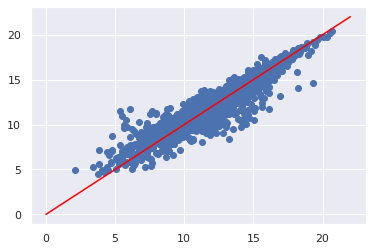

In [83]:
#視聴数が少ないデータが上手く予測できていない
plt.scatter(y_val,valid_pred)
plt.plot([0,22],[0,22],color='red')

In [84]:
#どのようなデータの予測誤差が大きいかを調べる
x_train['loss'] = (y_val-pd.Series(valid_pred))**2

In [85]:
tmp_train = pd.concat([combine[0],x_train['loss']],axis=1)

In [86]:
#提出用に予測値を出力
dtrain = xgb.DMatrix(train_validation.drop('log_y',axis=1),train_validation['log_y'])
dtest = xgb.DMatrix(test_dataset)
params = {'objective':'reg:squarederror',
          'eval_metric':'rmse',
          'random_state':1,
          'eta':0.1,
          'max_depth':8,
          'gamma':2,
          'min_child_weight':4
          }
num_round = 110
model = xgb.train(params,dtrain,num_round)
log_test_pred = model.predict(dtest)
test_pred = np.exp(log_test_pred).astype(int)

In [87]:
test_pred.astype(int)

array([ 283127, 3147965,  911278, ...,    8501,   79230, 6933828])

In [88]:
submission = pd.concat([test['id'],pd.Series(test_pred,name='y')],axis=1)

In [89]:
submission

,id,y
0,1,283127
1,2,3147965
2,3,911278
3,4,172298
4,5,227
...,...,...
29577,29578,1088612
29578,29579,227622
29579,29580,8501
29580,29581,79230


In [90]:
submission.to_csv('gdrive/My Drive/probspace_youtube/submission.csv',index=False)